In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras import layers, models, applications
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2
import random
from tensorflow import keras
print("Done")

Done


In [4]:
device_name = tf.test.gpu_device_name()

if "GPU" not in device_name:
    print("GPU device not found")
    
print('Found GPU at: {}'.format(device_name))

print("GPU", "available (YESS!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

Found GPU at: /device:GPU:0
GPU available (YESS!!!!)


In [2]:
strategy = tf.distribute.MirroredStrategy()
num_of_imgs = 1800
np.random.seed(42)
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
TRAIN_PATH = "/kaggle/input/tusimple-preprocessed/tusimple_preprocessed/training/frames"
TRAIN_MASKS_PATH = '/kaggle/input/tusimple-preprocessed/tusimple_preprocessed/training/lane-masks'
TEST_PATH = '/kaggle/input/tusimple-preprocessed/tusimple_preprocessed/test/frames'
TEST_MASKS_PATH = '/kaggle/input/tusimple-preprocessed/tusimple_preprocessed/test/lane-masks'

train_image_files = os.listdir(TRAIN_PATH)
train_mask_files = os.listdir(TRAIN_MASKS_PATH)
test_image_files = os.listdir(TEST_PATH)
test_mask_files = os.listdir(TEST_MASKS_PATH)

X_train = np.zeros((num_of_imgs, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
Y_train = np.zeros((num_of_imgs, IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)


images = []
masks = []
for n, image_file in enumerate(train_image_files):
    if os.path.splitext(image_file)[1].lower() == ".jpg" and n < num_of_imgs:
      image_path = os.path.join(TRAIN_PATH, image_file)
      image = cv2.imread(image_path)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      image = cv2.resize(image, (IMG_WIDTH,IMG_HEIGHT))
      image = image / 255

      images.append(image)

mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.uint8)
for n, mask_file in enumerate(train_mask_files):
    if os.path.splitext(mask_file)[1].lower() == ".jpg" and n < num_of_imgs:
      mask_path = os.path.join(TRAIN_MASKS_PATH, mask_file)
      mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) 
      mask = cv2.resize(mask, (IMG_WIDTH,IMG_HEIGHT))
      mask = mask / 255.0  # Normalize to [0, 1]

      masks.append(np.expand_dims(mask, axis=-1))


X_train, Y_train = np.array(images), np.array(masks)
print(f"X_train: {X_train.shape}")
print(f"Y_train: {Y_train.shape}")

for i in range(len(Y_train)):
    Y_train[i][Y_train[i] < 0.5] = 0
    Y_train[i][Y_train[i] >= 0.5] = 1
print(np.unique(Y_train[5]))

X_train: (1800, 256, 256, 3)
Y_train: (1800, 256, 256, 1)
[0. 1.]


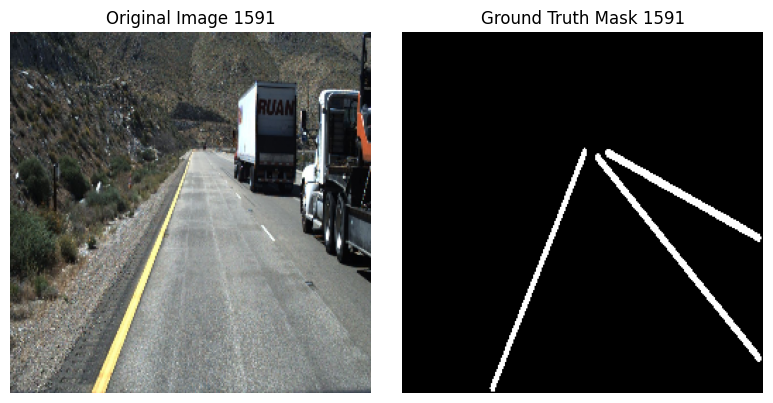

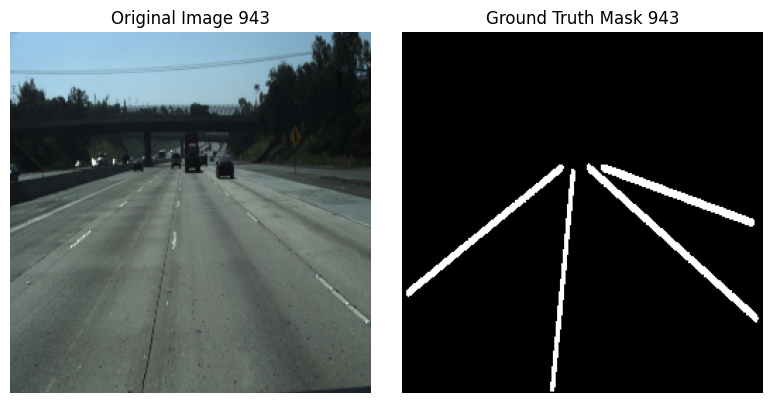

In [4]:
num_images_to_display = 2
selected_imgs = np.random.choice(len(X_train), num_images_to_display, replace=False)

for i, idx in enumerate(selected_imgs):
    plt.figure(figsize=(8, 4))
    
    plt.subplot(1, 2, 1)
    plt.imshow(X_train[idx])
    plt.title(f"Original Image {idx}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(Y_train[idx].squeeze(), cmap='gray')
    plt.title(f"Ground Truth Mask {idx}")
    plt.axis('off')


    plt.tight_layout()

    plt.show()

In [3]:
def augment_data(image, mask):
    # Random horizontal flip for both image and mask
    if tf.random.uniform(()) > 0.5:                    
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)

    # Only on image:
    image = tf.image.random_contrast(image, 0.2, 0.6)  
    image = tf.image.random_brightness(image, max_delta=0.4)   

    return image, mask

def create_augmented_dataset(X_train, Y_train, batch_size, augment_fraction=0.3, augment_probability=0.5): 
    original_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))

    # Create augmented dataset with conditional augmentation
    augmented_dataset = original_dataset.map(
        lambda x, y: tf.cond(tf.random.uniform(()) < augment_probability, lambda: augment_data(x, y), lambda: (x, y)),
        num_parallel_calls=tf.data.experimental.AUTOTUNE
    )

    augmented_dataset = augmented_dataset.filter(lambda x, y: tf.random.uniform(()) < augment_fraction)

    combined_dataset = original_dataset.concatenate(augmented_dataset)
    combined_dataset = combined_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

    return combined_dataset

batch_size = 16

train_size = int(0.75 * len(X_train))

X_train_split, Y_train_split = X_train[:train_size], Y_train[:train_size]
X_val_split, Y_val_split = X_train[train_size:], Y_train[train_size:]

train_dataset = create_augmented_dataset(X_train_split, Y_train_split, batch_size=batch_size)

# Validation set without augmentation
val_dataset = tf.data.Dataset.from_tensor_slices((X_val_split, Y_val_split))
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

train_length = sum(1 for _ in train_dataset)
val_length = sum(1 for _ in val_dataset)

print("Training dataset length:", train_length)
print("Validation dataset length:", val_length)

Training dataset length: 135
Validation dataset length: 29


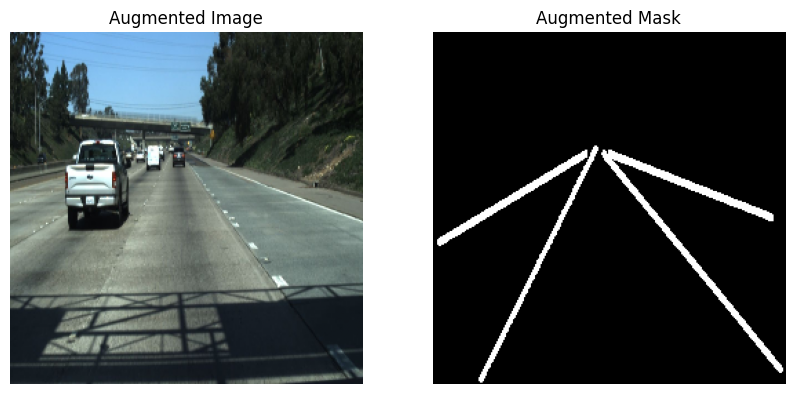

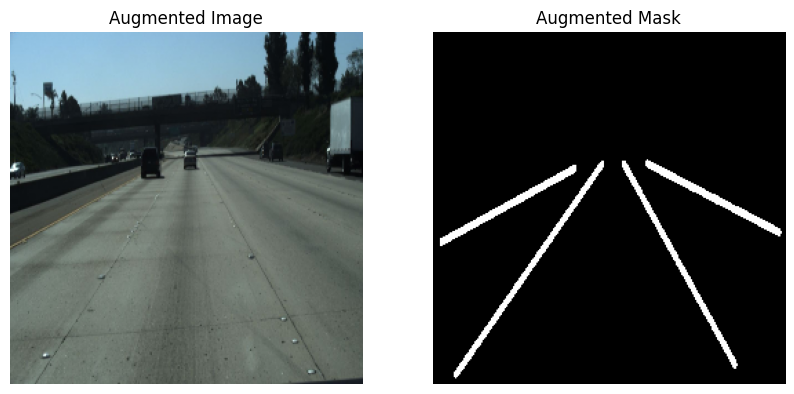

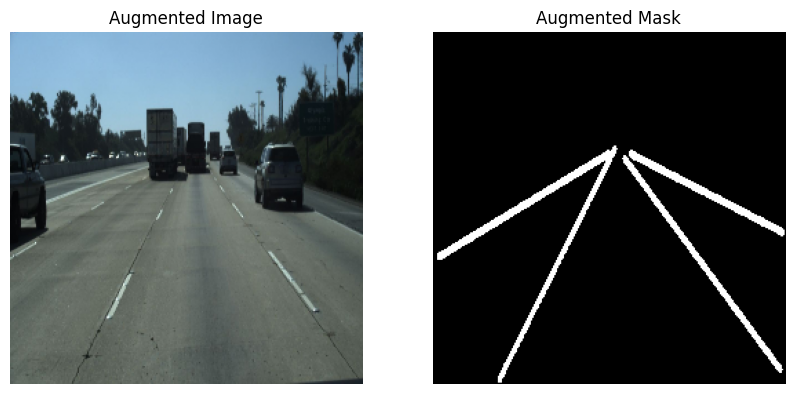

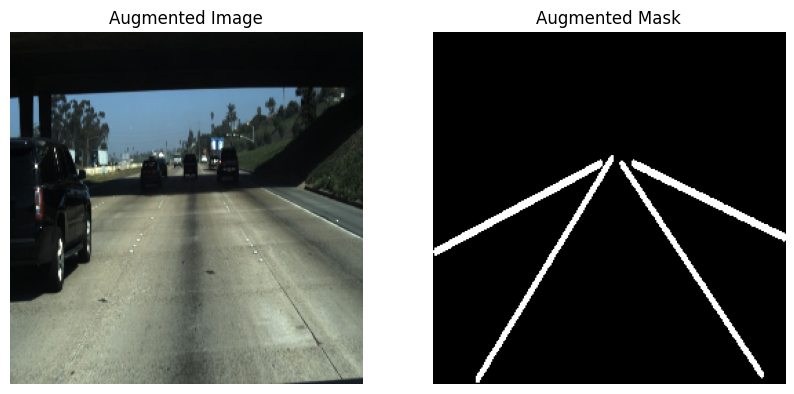

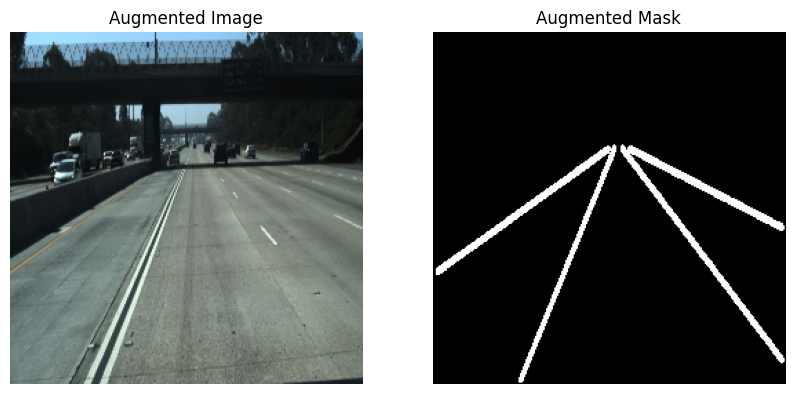

In [33]:
# Extract one batch
for images, masks in train_dataset.take(1):
    for i in range(images.shape[0]):
        if i == 5:
            break
        else:
            plt.figure(figsize=(10, 5))
            
            plt.subplot(1, 2, 1)
            plt.imshow(images[i])
            plt.title('Augmented Image')
            plt.axis('off')
    
            plt.subplot(1, 2, 2)
            plt.imshow(masks[i], cmap='gray')
            plt.title('Augmented Mask')
            plt.axis('off')
    
            plt.show()

In [5]:
def resnet50_encoder(input_shape):
    base_model = applications.ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    layer_names = [
        'conv1_relu',      
        'conv2_block3_out',
        'conv3_block4_out',
        'conv4_block6_out',
        'conv5_block3_out' 
    ]
    layers_output = [base_model.get_layer(name).output for name in layer_names]
    return models.Model(inputs=base_model.input, outputs=layers_output)


def spatial_attention_module(input_tensor):

    avg_pool = tf.keras.layers.GlobalAveragePooling2D(keepdims=True)(input_tensor)
    max_pool = tf.keras.layers.GlobalMaxPooling2D(keepdims=True)(input_tensor)
    
    concat = tf.keras.layers.Concatenate(axis=-1)([avg_pool, max_pool])
    attention_map = tf.keras.layers.Conv2D(1, (7, 7), padding='same', activation='sigmoid')(concat)
    
    return input_tensor * attention_map


def unet_decoder(encoder_outputs, dropout_rate=0.2):
    x = encoder_outputs[-1]  # Start with the deepest feature map (8x8x512)

    # Add a transition layer to reduce channels from 2048 to 512
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = layers.Dropout(dropout_rate)(x)
    
    # Upsample from 8x8 to 16x16 and add spatial attention to the skip connection
    x = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(x)
    skip1 = spatial_attention_module(encoder_outputs[-2]) 
    x = layers.concatenate([x, skip1])
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)

    # Upsample from 16x16 to 32x32
    x = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
    # skip2 = spatial_attention_module(encoder_outputs[-3])  # Apply spatial attention
    x = layers.concatenate([x, encoder_outputs[-3]])
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)

    # Upsample from 32x32 to 64x64
    x = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
    # skip3 = spatial_attention_module(encoder_outputs[-4])  # Apply spatial attention
    x = layers.concatenate([x, encoder_outputs[-4]])
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)

    # Upsample from 64x64 to 128x128
    x = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
    skip4 = spatial_attention_module(encoder_outputs[-5])  # Apply spatial attention
    x = layers.concatenate([x, skip4])
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)

    # Final upsampling to match the target size
    x = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)

    return x




def build_resnet50_unet(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    encoder = resnet50_encoder(input_shape)
    encoder_outputs = encoder(inputs)
    
    decoder_output = unet_decoder(encoder_outputs)
    
    outputs = layers.Conv2D(num_classes, (1, 1), activation='sigmoid')(decoder_output)
    model = models.Model(inputs, outputs)
    return model

input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
num_classes = 1  

In [25]:
model_plot = build_resnet50_unet(input_shape, num_classes)
tf.keras.utils.plot_model(model_plot, to_file="unet_resnet_attention_plot.png", show_shapes=True, show_layer_names=True)

In [28]:
# baisc unet

def spatial_attention_module(input_tensor):
    # Average and max pooling across channels
    avg_pool = tf.keras.layers.GlobalAveragePooling2D(keepdims=True)(input_tensor)
    max_pool = tf.keras.layers.GlobalMaxPooling2D(keepdims=True)(input_tensor)
    
    concat = tf.keras.layers.Concatenate(axis=-1)([avg_pool, max_pool])
    attention_map = tf.keras.layers.Conv2D(1, (7, 7), padding='same', activation='sigmoid')(concat)
    
    return input_tensor * attention_map


def create_unet_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)):
    inputs = tf.keras.layers.Input(input_shape)
    s = inputs

    # Contraction path
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = tf.keras.layers.Dropout(0.3)(c5)
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    
    # Expansive path
    u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    skip1 = spatial_attention_module(c4)  # Apply spatial attention
    u6 = tf.keras.layers.concatenate([u6, skip1])
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = tf.keras.layers.Dropout(0.2)(c6)
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    # skip2 = spatial_attention_module(c3)  # Apply spatial attention
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = tf.keras.layers.Dropout(0.2)(c7)
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    # skip3 = spatial_attention_module(c2)  # Apply spatial attention
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = tf.keras.layers.Dropout(0.1)(c8)
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    
    u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    skip4 = spatial_attention_module(c1)  # Apply spatial attention
    u9 = tf.keras.layers.concatenate([u9, skip4])
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = tf.keras.layers.Dropout(0.1)(c9)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
#     model.summary()
    return model

input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [ ]:
with strategy.scope():
    model = build_resnet50_unet(input_shape, num_classes)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["binary_accuracy", 
                                                                         "accuracy", 
                                                                         tf.keras.metrics.BinaryIoU(target_class_ids=[0, 1], threshold=0.5), 
                                                                         tf.keras.metrics.FalseNegatives()
                                                                        ])

callbacks = [
         tf.keras.callbacks.CSVLogger('/kaggle/working/log_model_unet_aug+_att_4.csv', append=False),
         tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1, min_delta=0.001, min_lr=0.00001),
         tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_binary_io_u', mode="min"),
         tf.keras.callbacks.ModelCheckpoint('/kaggle/working/model_unet_aug+_att_4.keras', verbose=1, save_best_only=True),
        ]

results = model.fit(train_dataset, validation_data=val_dataset, epochs=25, steps_per_epoch=None, callbacks=callbacks)
# without augmentation: 
# results = model.fit(X_train, Y_train, batch_size=16, epochs=25, steps_per_epoch=None,validation_split=0.25, callbacks=callbacks, shuffle=True)

Epoch 1/25


2024-11-27 14:44:30.632185: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/cond/else/_1780/cond/StatefulPartitionedCall/functional_7_1/dropout_5_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


    135/Unknown 189s 497ms/step - binary_io_u_1: 0.4738 - false_negatives_1: 1514396.8750 - loss: 0.1856
Epoch 1: val_loss improved from inf to 0.16118, saving model to /kaggle/working/model_unet_aug+_att_4.keras


/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_binary_io_u` which is not available. Available metrics are: binary_io_u_1,false_negatives_1,loss,val_binary_io_u_1,val_false_negatives_1,val_loss,learning_rate
  current = self.get_monitor_value(logs)


135/135 ━━━━━━━━━━━━━━━━━━━━ 203s 596ms/step - binary_io_u_1: 0.4738 - false_negatives_1: 1525383.6250 - loss: 0.1851 - val_binary_io_u_1: 0.4784 - val_false_negatives_1: 635990.0000 - val_loss: 0.1612 - learning_rate: 0.0010
Epoch 2/25
136/135 ━━━━━━━━━━━━━━━━━━━━ 0s 544ms/step - binary_io_u_1: 0.5090 - false_negatives_1: 1393306.0000 - loss: 0.0870
Epoch 2: val_loss did not improve from 0.16118
135/135 ━━━━━━━━━━━━━━━━━━━━ 84s 584ms/step - binary_io_u_1: 0.5095 - false_negatives_1: 1400752.2500 - loss: 0.0869 - val_binary_io_u_1: 0.4789 - val_false_negatives_1: 635402.0000 - val_loss: 0.5093 - learning_rate: 0.0010
Epoch 3/25
134/135 ━━━━━━━━━━━━━━━━━━━━ 0s 554ms/step - binary_io_u_1: 0.7101 - false_negatives_1: 684314.5625 - loss: 0.0695
Epoch 3: val_loss improved from 0.16118 to 0.11525, saving model to /kaggle/working/model_unet_aug+_att_4.keras
135/135 ━━━━━━━━━━━━━━━━━━━━ 87s 608ms/step - binary_io_u_1: 0.7102 - false_negatives_1: 688544.3125 - loss: 0.0695 - val_binary_io_u_1: 

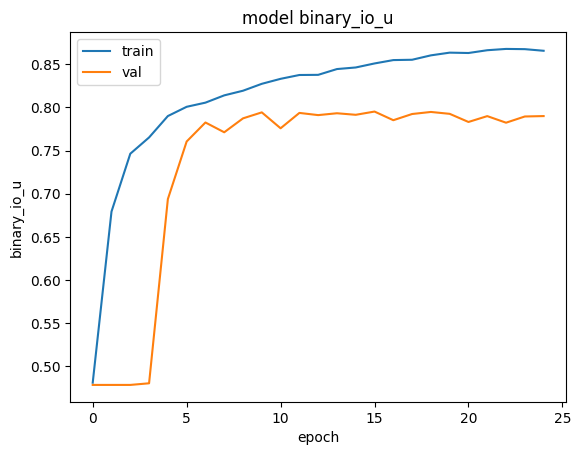

In [14]:
plt.plot(results.history['binary_io_u_1'])
plt.plot(results.history['val_binary_io_u_1'])
plt.title('model binary_io_u')
plt.ylabel('binary_io_u')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [13]:
results.history.keys()

dict_keys(['accuracy', 'binary_accuracy', 'binary_io_u', 'false_negatives', 'loss', 'val_accuracy', 'val_binary_accuracy', 'val_binary_io_u', 'val_false_negatives', 'val_loss', 'learning_rate'])

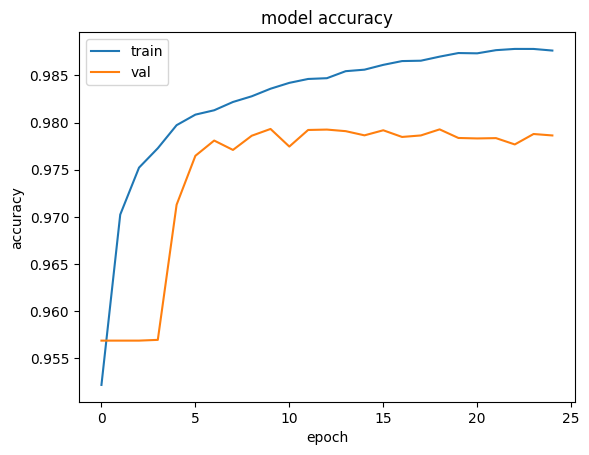

In [18]:
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

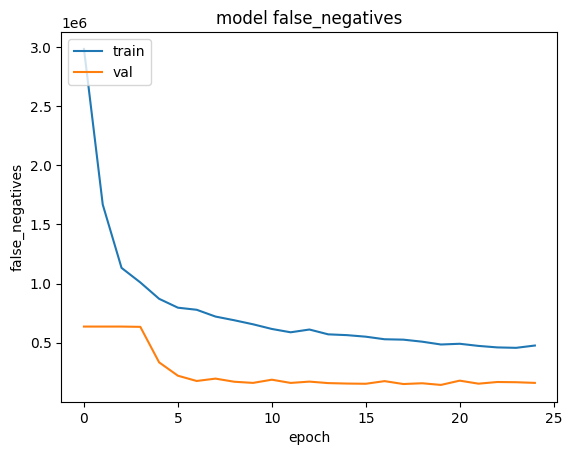

In [19]:
plt.plot(results.history['false_negatives_3'])
plt.plot(results.history['val_false_negatives_3'])
plt.title('model false_negatives')
plt.ylabel('false_negatives')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

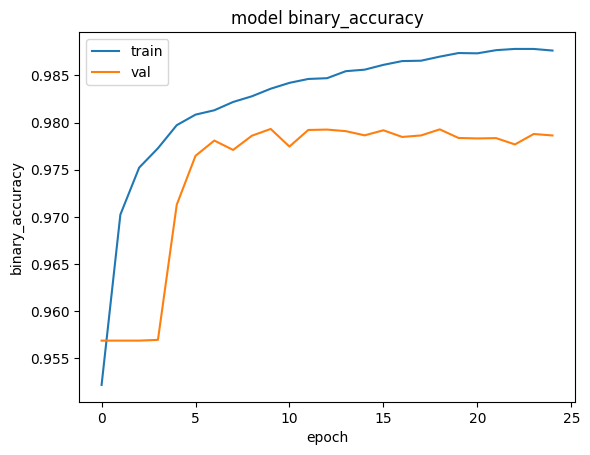

In [20]:
plt.plot(results.history['binary_accuracy'])
plt.plot(results.history['val_binary_accuracy'])
plt.title('model binary_accuracy')
plt.ylabel('binary_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

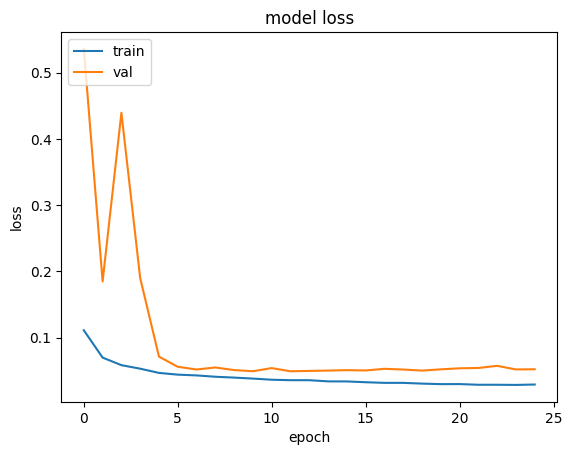

In [21]:
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

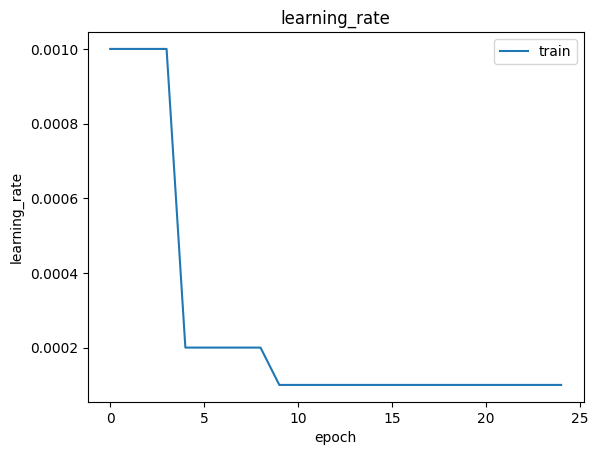

In [22]:
plt.plot(results.history['learning_rate'])
plt.title('learning_rate')
plt.ylabel('learning_rate')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [11]:
num_of_test_imgs = 320

X_test = np.zeros((num_of_test_imgs, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
Y_test = np.zeros((num_of_test_imgs, IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)

test = []
test_masks = []
for n, image_file in enumerate(test_image_files):
    if os.path.splitext(image_file)[1].lower() == ".jpg" and n < num_of_test_imgs:
        image_path = os.path.join(TEST_PATH, image_file)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (256,256))
        image = image / 255

        test.append(image)

mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.uint8)
for n, mask_file in enumerate(test_mask_files):
    if os.path.splitext(mask_file)[1].lower() == ".jpg" and n < num_of_test_imgs:
        mask_path = os.path.join(TEST_MASKS_PATH, mask_file)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (256,256))
        mask = mask / 255.0

        test_masks.append(np.expand_dims(mask, axis=-1))

X_test, Y_test = np.array(test), np.array(test_masks)
print("creating X_test, Y_test________DONE")
print(X_test.shape)
print(Y_test.shape)

for i in range(len(Y_test)):
    Y_test[i][Y_test[i] < 0.5] = 0
    Y_test[i][Y_test[i] >= 0.5] = 1
print(np.unique(Y_test[5]))

creating X_test, Y_test________DONE
(320, 256, 256, 3)
(320, 256, 256, 1)
[0. 1.]


In [12]:
y_pred = model.predict(X_test)
print("prediction done")
print(y_pred.shape)

print(len(np.unique(y_pred[5])))
for i in range(len(y_pred)):
    y_pred[i][y_pred[i] < 0.5] = 0
    y_pred[i][y_pred[i] >= 0.5] = 1
print(np.unique(y_pred[5]))

10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 179ms/step
prediction done
(320, 256, 256, 1)
65342
[0. 1.]


selected_indices:   [167 230  25]


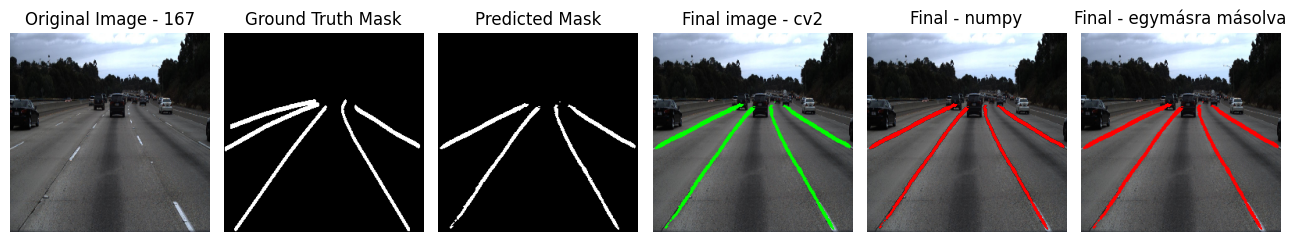

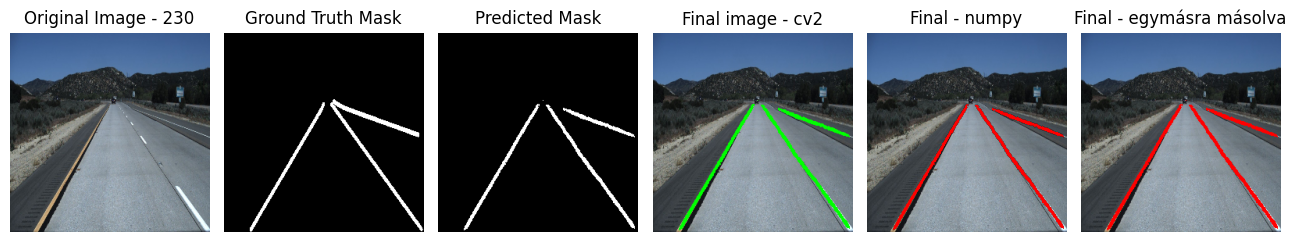

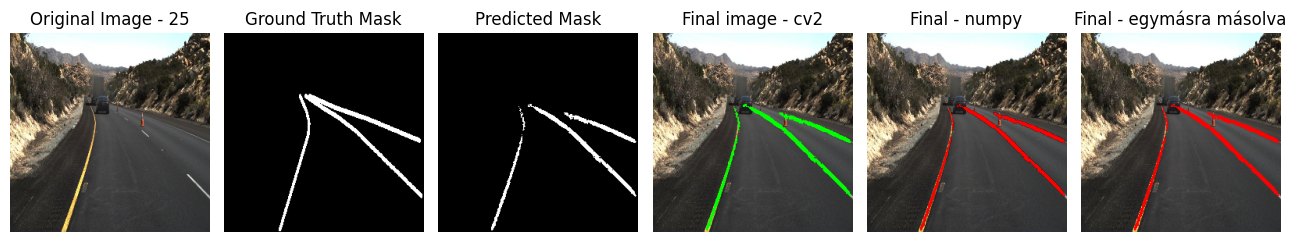

In [22]:
num_samples = 3

selected_indices = np.random.choice(len(X_test), num_samples, replace=False)
print("selected_indices:  ", selected_indices)

for i, idx in enumerate(selected_indices):
    plt.figure(figsize=(13,18))
    
# original image
    plt.subplot(i+1,6,1)
    plt.imshow(X_test[idx])
    plt.title(f"Original Image - {idx}")
    plt.axis('off')

# ground truth mask
    plt.subplot(i+1,6,2)
    plt.imshow(Y_test[idx].squeeze(), cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis('off')

# predicted mask
    plt.subplot(i+1,6,3)
    plt.imshow(y_pred[idx].squeeze(), cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')
    
#draw pred onto original image
    _, binary_mask = cv2.threshold(y_pred[idx], 0.5, 1.0, cv2.THRESH_BINARY)
    binary_mask = (binary_mask * 255).astype(np.uint8)
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour_image = X_test[idx].copy()
    cv2.drawContours(contour_image, contours, -1, (0, 255, 0), -1)
    
    plt.subplot(i+1,6,4)
    plt.imshow(contour_image.squeeze())
    plt.title("Final image - cv2")
    plt.axis('off')
    
#numpy
    plt.subplot(i+1,6, 5)
    plt.imshow(np.squeeze(X_test[idx]))
    mask = np.where(y_pred[idx].squeeze() > 0.5, 255, 0).astype(np.uint8)
    rgba_image = np.zeros((256, 256, 4), dtype=np.uint8)
    # Set the red channel to 255 where the mask is 255, else 0
    rgba_image[:, :, 0] = np.where(mask == 255, 255, 0)  # Red channel
    rgba_image[:, :, 1] = 0  # Green channel
    rgba_image[:, :, 2] = 0  # Blue channel
    rgba_image[:, :, 3] = mask  # Alpha channel
    
    plt.imshow(X_test[idx])
    plt.imshow(rgba_image)
    plt.title("Final - numpy")
    plt.axis('off')
    
#draw with mask
    plt.subplot(i+1,6, 6)
    img = X_test[idx]
    pred = y_pred[idx]
    mask = (pred > 0.5).astype(np.uint8)
    mask_resize = cv2.resize(mask, ((img.shape[1]), (img.shape[0])), interpolation = cv2.INTER_CUBIC)
    img[mask_resize==1, :] = (255, 0, 0)
    
    plt.imshow(img)
    plt.title("Final - draw with mask")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [15]:
def precision_score(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    total_pixel_pred = np.sum(pred_mask)
    precision = np.mean(intersect/total_pixel_pred)
    return round(precision, 3)

def recall_score(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    total_pixel_truth = np.sum(groundtruth_mask)
    recall = np.mean(intersect/total_pixel_truth)
    return round(recall, 3)

def accuracy(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    union = np.sum(pred_mask) + np.sum(groundtruth_mask) - intersect
    xor = np.sum(groundtruth_mask==pred_mask)
    acc = np.mean(xor/(union + xor - intersect))
    return round(acc, 3)

def dice_coef(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    total_sum = np.sum(pred_mask) + np.sum(groundtruth_mask)
    dice = np.mean(2*intersect/total_sum)
    return round(dice, 3)

def iou(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    union = np.sum(pred_mask) + np.sum(groundtruth_mask) - intersect
    iou = np.mean(intersect/union)
    return round(iou, 3)

def f1_score(precision,recall):
    f1_score = 2 * (precision * recall) / (precision + recall)
    return round(f1_score, 3)


pre_score = 0
rec_score = 0
acc = 0
dice_c = 0
io_u = 0
f1 = 0

for num in range(len(y_pred)):
    pre_score += precision_score(Y_test[num].flatten(),y_pred[num].flatten())
    rec_score += recall_score(Y_test[num].flatten(),y_pred[num].flatten())
    acc += accuracy(Y_test[num].flatten(),y_pred[num].flatten())
    dice_c += dice_coef(Y_test[num].flatten(),y_pred[num].flatten())
    io_u += iou(Y_test[num].flatten(),y_pred[num].flatten())
    f1 += f1_score(pre_score,rec_score)

pre_score = round(pre_score / (len(y_pred)), 3)
rec_score = round(rec_score / (len(y_pred)), 3)
accuracy = round(acc / (len(y_pred)), 3)
dice_coef = round(dice_c / (len(y_pred)), 3)
iou = round(io_u / (len(y_pred)), 3)
f1_score = f1_score(pre_score,rec_score)
    
print(f"Precision score= {pre_score}")
print(f"Recall Score= {rec_score}")
print(f"Accuracy Score= {accuracy}")
print(f"Dice Score= {dice_coef}")
print(f"Intersection Over Union= {iou}")
print(f"F1 score= {f1_score}")

NameError: name 'y_pred' is not defined